In [3]:
%load_ext zipline
%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The zipline extension is already loaded. To reload it, use:
  %reload_ext zipline
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [4]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

from collections import OrderedDict
import pytz

# необходимые функции zipline
from zipline.api import (order, record, symbol, set_benchmark, order_target_percent, get_open_orders, order_target, 
                        schedule_function, date_rules, time_rules, order_percent, symbols)
# комиссии
from zipline.finance import commission
from zipline.finance import slippage
from zipline.finance.slippage import SlippageModel

# выбор календаря по которому происходит торговля
from trading_calendars.always_open import AlwaysOpenCalendar

import zipline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date

# aинансовые данные
from yahoofinancials import YahooFinancials

# отчёт
import pyfolio as pf

# import helper functions 
import qf_helper_functions as qf

import pypfopt
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

import pylab

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
from matplotlib import mlab
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
import matplotlib.patches as patches
%matplotlib inline

plt.style.use('default')
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 200

#векторный формат
%config InlineBackend.figure_format = 'svg'

from tqdm import tqdm

from __future__ import division
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize

In [5]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]# covariance table
    x_t = pars[1] # risk target in percent of portfolio risk
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def long_only_constraint(x):
    return x

In [6]:
# Custom slippage model
class InstantSlippage(SlippageModel):
    
    def process_order(self, data, order):
        # Use price from previous bar
        price = data.history(order.sid, 'price', 2, '1d')[0]
        
        # Alternative: Use current bar's open, instead of close
        # price = data.current(order.sid, 'open')

        return (price, order.amount)

# Прогружаем данные

In [7]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close', 'adjclose', 'volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date), color='green');
    plt.yscale('log')

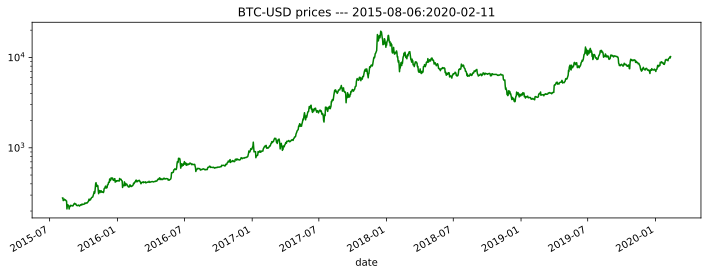

In [8]:
download_csv_data(ticker='BTC-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-11', 
                  freq='daily', 
                  path='data/BTC.csv')

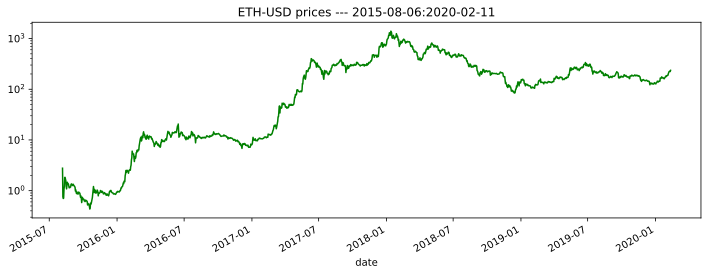

In [9]:
download_csv_data(ticker='ETH-USD', 
                  start_date='2015-08-06', 
                  end_date='2020-02-11', 
                  freq='daily', 
                  path='data/ETH.csv')

In [10]:
# Список финансовых инструментов в портфеле
TIKERS = ['BTC', 'ETH']

# Данные которые будут использоваться в дальнейшем
COLUMNS = ['open', 'close', 'adjclose']

In [11]:
data = OrderedDict()

for tiker in TIKERS:
    data[tiker] = pd.read_csv("data/{}.csv".format(tiker), index_col=0, parse_dates=['date'])
    data[tiker] = data[tiker][COLUMNS]
    data[tiker] = data[tiker].resample("1d").mean()
    data[tiker].fillna(method="ffill", inplace=True)
    data[tiker]['close'] = data[tiker]['adjclose']
    data[tiker]['open'] = data[tiker]['adjclose']
    del data[tiker]['adjclose']
    print(data[tiker].head())
COLUMNS = ['open', 'close']

                  open       close
date                              
2015-08-05  278.576996  278.576996
2015-08-06  279.584991  279.584991
2015-08-07  260.997009  260.997009
2015-08-08  265.083008  265.083008
2015-08-09  264.470001  264.470001
                open     close
date                          
2015-08-06  2.772120  2.772120
2015-08-07  0.753325  0.753325
2015-08-08  0.701897  0.701897
2015-08-09  0.708448  0.708448
2015-08-10  1.067860  1.067860


In [12]:
panel = pd.Panel(data)
panel.minor_axis = COLUMNS
panel.major_axis = panel.major_axis.tz_localize(pytz.utc)
print(panel)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1652 (major_axis) x 2 (minor_axis)
Items axis: BTC to ETH
Major_axis axis: 2015-08-05 00:00:00+00:00 to 2020-02-11 00:00:00+00:00
Minor_axis axis: open to close


# Взаимная корреляция

In [13]:
data_corr = data['BTC']
for tiker in TIKERS:
    data_corr[tiker] = data[tiker]['close']
del data_corr['open']
del data_corr['close']
data_corr.corr()

,BTC,ETH
BTC,1.000000,0.762229
ETH,0.762229,1.000000


# Risk

### Определяем стартовые переменные

In [196]:
num_assets = len(TIKERS)
performance_list = []
COMMISSION = 0.0007
WEIGHTS = [1]


# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
stock_weights = []
sharpe_ratio = []

In [197]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['BTC']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

Bitcoin = perf.algorithm_period_return

Bitcoin = 100 * (1 + Bitcoin)

Bitcoin = Bitcoin.rename('Bitcoin')

In [198]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = ['ETH']
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = [1]
    context.n_assets = len(context.assets)

    context.window = 1

    context.time = 0
        
    
def handle_data(context, data):
    
    if context.time == 0:

        # extract prices
        prices = data.history(context.assets, fields='price', bar_count=context.window, frequency='1d')

        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])

        context.time += 1
    
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

Ethereum = perf.algorithm_period_return

Ethereum = 100 * (1 + Ethereum)

Ethereum = Ethereum.rename('Ethereum')

# Визуализация результатов

In [199]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [200]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,114.973970,73.863666,1.405131
1,275.574361,124.531664,1.651083


In [201]:
asset_list = TIKERS

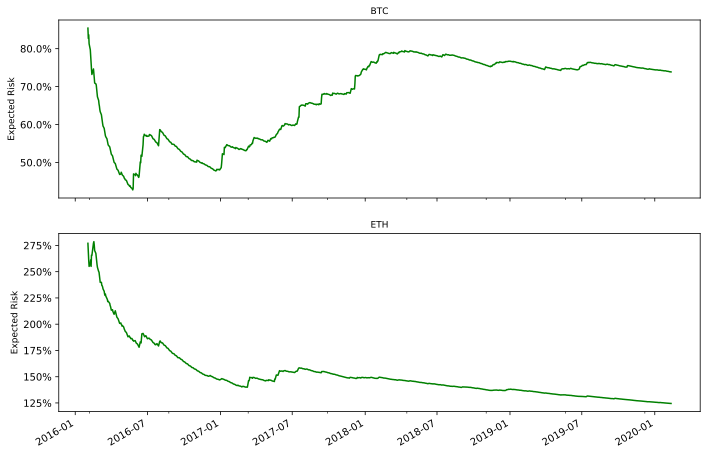

In [202]:
risk_list = []

fig, ax = plt.subplots(len(TIKERS), 1, sharex=True, figsize=[11.5, 8])

for i in range(0, len(TIKERS)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

In [203]:
fig.savefig('Risk.png', transparent=True, dpi=1000, bbox_inches="tight")

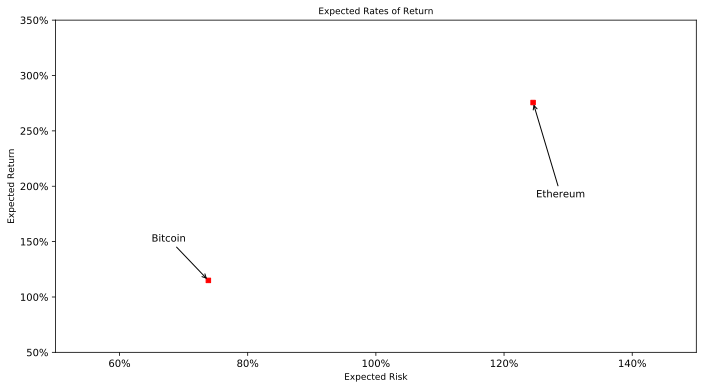

In [204]:
#fig, ax = plt.subplots()
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 150), ylim=(50, 350))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(65, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(125, 190),
             arrowprops=dict(arrowstyle="->"))

plt.show()

fig.savefig('Assets.png', transparent=False, dpi=500, bbox_inches="tight")

In [205]:
Corr = data_corr.corr()
Corr = Corr.as_matrix()

In [206]:
V = Corr.copy()

In [207]:
w0 = df['Volatility']/100
w0 = w0.values.tolist()

In [208]:
for i in range(0, len(Corr)):
    for j in range(0, len(Corr)):
        V[i][j] = Corr[i][j] * w0[i] * w0[j]

In [209]:
TIKERS = ['BTC', 'ETH']

In [210]:
x_t = [0.5, 0.5] # your risk budget percent of total portfolio risk (equal risk)

cons = ({'type': 'eq', 'fun': total_weight_constraint}, {'type': 'ineq', 'fun': long_only_constraint})

res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, options={'disp': True})

w_rb = np.asmatrix(res.x)

w_rb = w_rb.tolist()[0]

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.64269675445e-07
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5


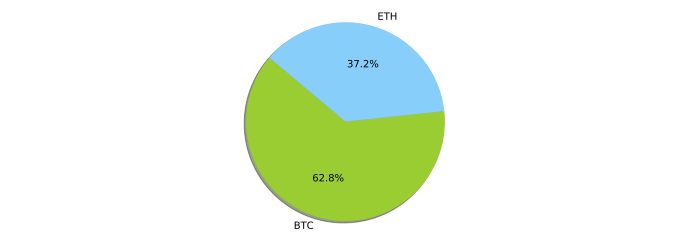

In [211]:
# Data to plot
labels = TIKERS
sizes = w_rb
colors = ['yellowgreen', 'lightskyblue', 'lightcoral', 'gold', 'pink' , 'lightgrey', 'khaki']
explode = (0, 0)  # explode 1st slice

# Plot
weight_pie = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
#plt.legend(labels, loc="best")
plt.show()

## Визуализация портфеля FIX REB

In [212]:
WEIGHTS = [0.65, 0.3491]
COMMISSION = 0.0007

In [213]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 50
    context.time = 0

In [214]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [215]:
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [216]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [217]:
RPP_FIX = perf.algorithm_period_return

RPP_FIX = 100 * (1 + RPP_FIX)

RPP_FIX = RPP_FIX.rename('Crypto Risk Parity Portfolio (frequency rebalance)')

In [218]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [219]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,114.973970,73.863666,1.405131
1,275.574361,124.531664,1.651083
2,246.191193,84.863302,1.881481


In [220]:
asset_list = ['BTC', 'ETH', 'Risk Parity Portfolio (Rebalance frequencies)']

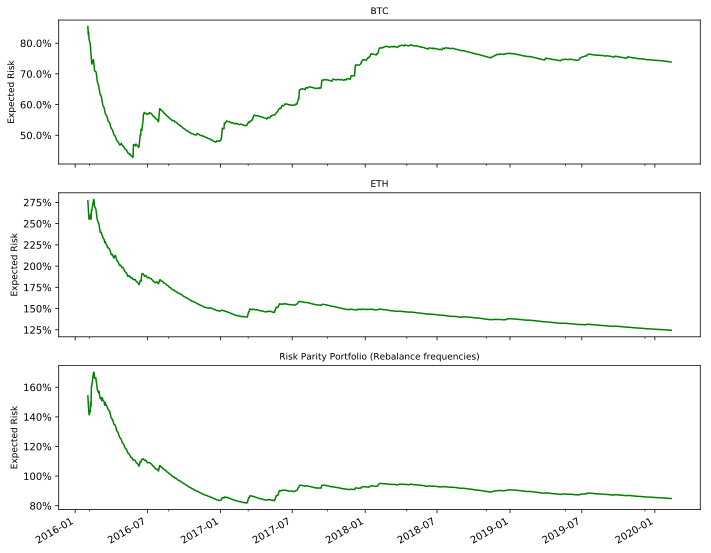

In [221]:
risk_list = []

fig, ax = plt.subplots(len(asset_list), 1, sharex=True, figsize=[11.5, 10])

for i in range(0, len(asset_list)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

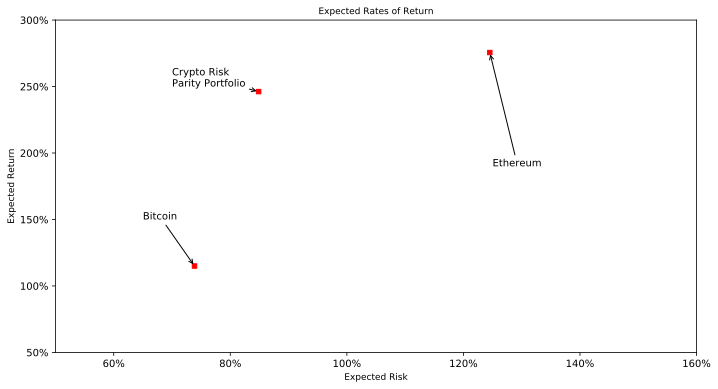

In [222]:
# plot frontier, max sharpe & min Volatility values with a scatterplot

ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 160), ylim=(50, 300))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(65, 150),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(125, 190),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Crypto Risk\nParity Portfolio', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(70, 250),
             arrowprops=dict(arrowstyle="->"))

plt.savefig('map.png', transparent=True, dpi=500, bbox_inches="tight")
plt.show()

## NOT FIX REB

In [223]:
TIKERS = ['BTC', 'ETH']

In [224]:
WEIGHTS = [0.65, 0.3491]
COMMISSION = 0.0007
DELTA = 0.2

In [225]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())
    
    #set_benchmark(symbol('BTC'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.rebalance_count = 0

    
    #context.rebalance_period = 63
    context.time = 0

In [226]:
def handle_data(context, data):
    
    
    if context.time == 0:
        
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])      
        context.time += 1
        
        
    else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                    for j, asset in enumerate(context.assets):
                        order_target_percent(asset, context.weights[j])
                        
                    context.rebalance_count += 1
                    context.time += 1
                        
                    return
                
                context.time += 1    

In [227]:
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [228]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)
    
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [229]:
RPP_NOTFIX = perf.algorithm_period_return

RPP_NOTFIX = 100 * (1 + RPP_NOTFIX)

RPP_NOTFIX = RPP_NOTFIX.rename('Crypto Risk Parity Portfolio (Allocation triggers)')

In [230]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [231]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,114.973970,73.863666,1.405131
1,275.574361,124.531664,1.651083
2,246.191193,84.863302,1.881481
3,217.100882,81.287280,1.822082


In [232]:
asset_list = ['BTC', 'ETH', 'RPP (Rebalance frequencies)', 'RPP (Allocation triggers)']

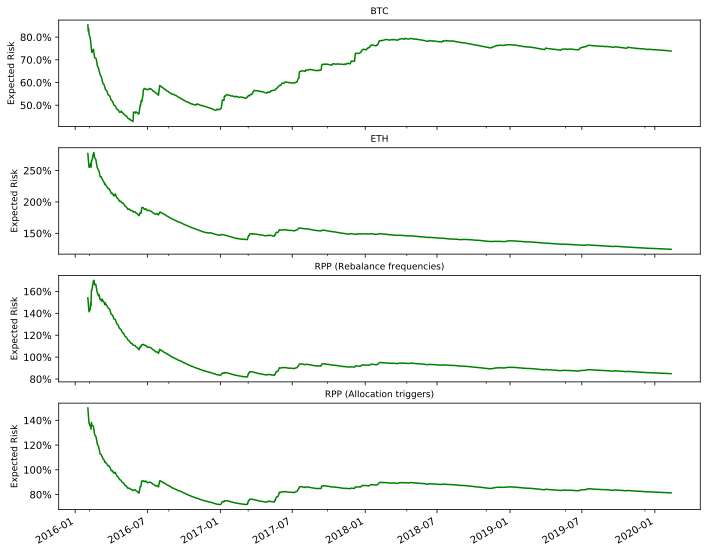

In [233]:
risk_list = []

fig, ax = plt.subplots(len(asset_list), 1, sharex=True, figsize=[11.5, 10])

for i in range(0, len(asset_list)):
    risk_list.append(performance_list[i].algo_volatility * 100)
    risk_list[i][15:].plot(ax=ax[i], color='g')
    ax[i].yaxis.set_major_formatter(mtick.PercentFormatter())
    ax[i].set_ylabel('Expected Risk', fontsize = 9)
    ax[i].set_title(asset_list[i], fontsize = 9)

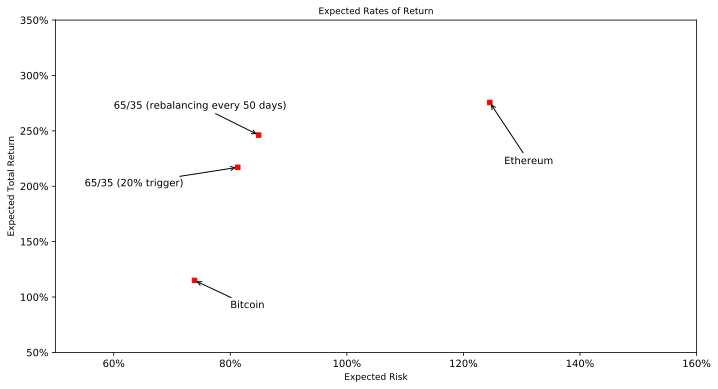

In [234]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 160), ylim=(50, 350))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 90),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(127, 220),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('65/35 (rebalancing every 50 days)', xy=(df.iloc[2]['Volatility'], df.iloc[2]['Returns']), xytext=(60, 270),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('65/35 (20% trigger)', xy=(df.iloc[3]['Volatility'], df.iloc[3]['Returns']), xytext=(55, 200),
             arrowprops=dict(arrowstyle="->"))

plt.savefig('RP_map.png', transparent=True, dpi=500, bbox_inches="tight")
plt.show()

In [235]:
RPP_NOTFIX = RPP_NOTFIX.rename('65/35 (20% trigger)')

In [236]:
RPP_FIX = RPP_FIX.rename('65/35 (rebalancing every 50 days)')

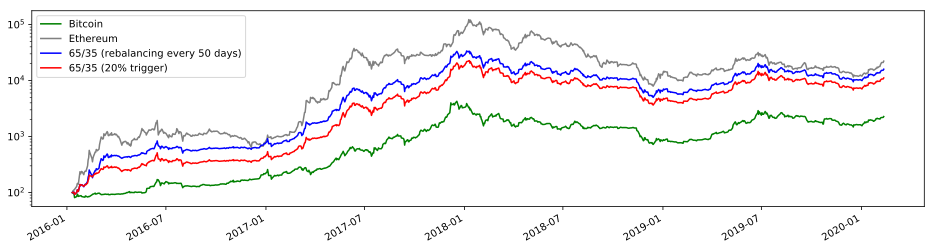

In [237]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
Bitcoin.plot(color='g')
Ethereum.plot(color='grey')
RPP_FIX.plot(color='b')
RPP_NOTFIX.plot(color='r')

#ax.set(ylim=(100, 16000))

#ax.set_ylabel('portfolio value in $')

plt.legend()
plt.yscale('log')
#ax.yaxis.tick_right()
plt.show()

#print('Final portfolio return: {}%'.format(np.round(RPP_Cash[0], 2)))
#print('Final benchmark return: {}%'.format(np.round(Bitcoin[0], 2)))

#print('Final portfolio return: {}%'.format(np.round(RPP_Cash[-1], 2)))
#print('Final benchmark return: {}%'.format(np.round(Bitcoin[-1], 2)))

In [238]:
fig.savefig('RPP.png', transparent=True, dpi=500, bbox_inches="tight")

In [239]:
WEIGHTS = [0.555, 0.299]
COMMISSION = 0.0007

In [240]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())

    #set_benchmark(symbol('BTC'))

    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]

    context.weights = WEIGHTS
    context.n_assets = len(context.assets)

    context.window = 1

    context.rebalance_period = 50
    context.time = 0

In [241]:
def handle_data(context, data):
    
    # Закупка и ребаллансировка
    if context.time == 0 or (context.time % context.rebalance_period == 0):
        
        
        # submit orders
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])
            
    
    context.time += 1

In [242]:
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [243]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [244]:
print(qf.get_performance_summary(returns).sharpe_ratio)
print(qf.get_performance_summary(returns).annualized_returns * 100)
print(qf.get_performance_summary(returns).annual_volatility * 100)

1.92109939491
216.636490693
74.0506471979


In [245]:
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [246]:
RPP_CASH_FIX = perf.algorithm_period_return

RPP_CASH_FIX = 100 * (1 + RPP_CASH_FIX)

RPP_CASH_FIX = RPP_CASH_FIX.rename('Risk Parity Portfolio + 15% Cash (rebalancing every 50 days)')

In [247]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [248]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,114.973970,73.863666,1.405131
1,275.574361,124.531664,1.651083
2,246.191193,84.863302,1.881481
3,217.100882,81.287280,1.822082
4,216.636491,74.050647,1.921099


In [249]:
WEIGHTS = [0.585, 0.315]
COMMISSION = 0.0007
DELTA = 0.2

In [250]:
def initialize(context):
    
    context.set_commission(commission.PerDollar(cost=COMMISSION))
    context.set_slippage(InstantSlippage())
    
    #set_benchmark(symbol('BTC'))
    
    context.tikers = TIKERS
    context.assets = [context.symbol(symbol) for symbol in context.tikers]
    
    context.weights = WEIGHTS
    context.n_assets = len(context.assets)
    
    context.rebalance_count = 0

    
    #context.rebalance_period = 63
    context.time = 0

In [251]:
def handle_data(context, data):
    
    
    if context.time == 0:
        
        for i, asset in enumerate(context.assets):
            order_target_percent(asset, context.weights[i])      
        context.time += 1
        
        
    else:
            for i, asset in enumerate(context.assets):
                if abs(context.portfolio.current_portfolio_weights.get(key = asset) - context.weights[i]) > DELTA:
                    for j, asset in enumerate(context.assets):
                        order_target_percent(asset, context.weights[j])
                        
                    context.rebalance_count += 1
                    context.time += 1
                        
                    return
                
                context.time += 1    

In [252]:
perf = zipline.run_algorithm(start=datetime(2016, 1, 10, 0, 0, 0, 0, pytz.utc),
                              end=datetime(2020, 2, 11, 0, 0, 0, 0, pytz.utc),
                              initialize=initialize,
                              capital_base=10000000,
                              handle_data=handle_data,
                              data=panel)

In [253]:
performance_list.append(perf)    
        
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perf)

In [254]:
print(qf.get_performance_summary(returns).sharpe_ratio)
print(qf.get_performance_summary(returns).annualized_returns * 100)
print(qf.get_performance_summary(returns).annual_volatility * 100)

1.83613693423
196.699616127
73.988341476


In [255]:
sharpe_ratio.append(qf.get_performance_summary(returns).sharpe_ratio)
port_returns.append(qf.get_performance_summary(returns).annualized_returns * 100)
port_volatility.append(qf.get_performance_summary(returns).annual_volatility * 100)
stock_weights.append(WEIGHTS)

In [256]:
RPP_CASH_NOTFIX = perf.algorithm_period_return

RPP_CASH_NOTFIX = 100 * (1 + RPP_CASH_NOTFIX)

RPP_CASH_NOTFIX = RPP_CASH_NOTFIX.rename('Risk Parity Portfolio + 10% Cash (20% trigger)')

In [257]:
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
#for counter,symbol in enumerate(TIKERS):
    #portfolio[symbol] = [Weight[counter] for Weight in stock_weights]
    
# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio']

# reorder dataframe columns
df = df[column_order]

In [258]:
df.head(7)

,Returns,Volatility,Sharpe Ratio
0,114.973970,73.863666,1.405131
1,275.574361,124.531664,1.651083
2,246.191193,84.863302,1.881481
3,217.100882,81.287280,1.822082
4,216.636491,74.050647,1.921099
5,196.699616,73.988341,1.836137


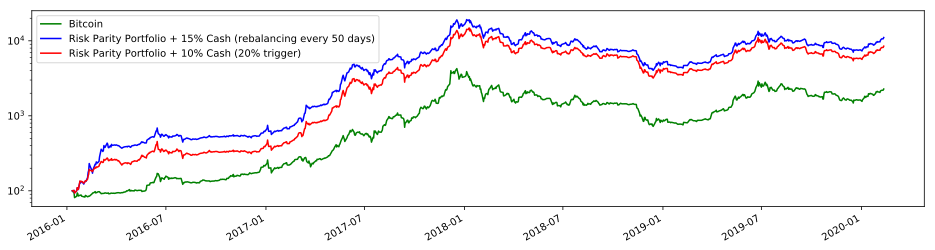

In [259]:
fig, ax = plt.subplots(figsize=[16, 4])

# portfolio value
Bitcoin.plot(color='g')
#Ethereum.plot(color='grey')
RPP_CASH_FIX.plot(color='b')
RPP_CASH_NOTFIX.plot(color='r')

#ax.set(ylim=(100, 16000))

#ax.set_ylabel('portfolio value in $')

plt.legend()
plt.yscale('log')
#ax.yaxis.tick_right()
plt.show()

#print('Final portfolio return: {}%'.format(np.round(RPP_Cash[0], 2)))
#print('Final benchmark return: {}%'.format(np.round(Bitcoin[0], 2)))

#print('Final portfolio return: {}%'.format(np.round(RPP_Cash[-1], 2)))
#print('Final benchmark return: {}%'.format(np.round(Bitcoin[-1], 2)))

In [260]:
fig.savefig('CASH_RPP.png', transparent=True, dpi=500, bbox_inches="tight")

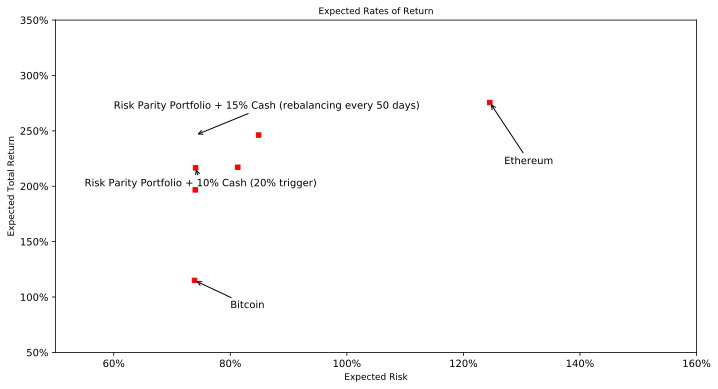

In [261]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
ax = df.plot.scatter(x='Volatility', y='Returns', marker = 's', color='r', edgecolors='r', figsize=(11.5, 6))
plt.xlabel('Expected Risk', fontsize = 9)
plt.ylabel('Expected Total Return', fontsize = 9)
plt.title('Expected Rates of Return', fontsize = 9)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set(xlim=(50, 160), ylim=(50, 350))

#https://matplotlib.org/3.1.1/tutorials/text/annotations.html

plt.annotate('Bitcoin', xy=(df.iloc[0]['Volatility'], df.iloc[0]['Returns']), xytext=(80, 90),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Ethereum', xy=(df.iloc[1]['Volatility'], df.iloc[1]['Returns']), xytext=(127, 220),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Risk Parity Portfolio + 15% Cash (rebalancing every 50 days)', xy=(df.iloc[4]['Volatility'], df.iloc[2]['Returns']), xytext=(60, 270),
             arrowprops=dict(arrowstyle="->"))

plt.annotate('Risk Parity Portfolio + 10% Cash (20% trigger)', xy=(df.iloc[5]['Volatility'], df.iloc[3]['Returns']), xytext=(55, 200),
             arrowprops=dict(arrowstyle="->"))

plt.savefig('RP_map.png', transparent=True, dpi=500, bbox_inches="tight")
plt.show()